In [123]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import time
from features import extract_features, calc_bin_spatial_features
%matplotlib inline

In [81]:
dist_pickle = pickle.load( open('Car_NoCar_LinearSVC.p', 'r' ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orientations"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["color_spatial_size"]
h_colorspace = dist_pickle["h_colorspace"]
s_colorspace = dist_pickle["s_colorspace"]
#hog_channel = dist_pickle["hog_channel"]
hog_channel = 'ALL'

In [82]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, cells_per_step, hog_channel='ALL', show_windows=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_roi = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = img_roi.shape
        img_roi = cv2.resize(img_roi, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    x_size = img_roi.shape[1]
    y_size = img_roi.shape[0]
    
    # Define blocks and steps as above
    #Number of Cells
    nxcells = x_size // pix_per_cell
    nycells = y_size // pix_per_cell
    #Number of Blocks
    nxblocks = (nxcells - cell_per_block) + 1 ##(W-F)/S + 1, W=ncells, F=cell_per_block, S=Stride=1
    nyblocks = (nycells - cell_per_block) + 1 
    #nxblocks = (x_size // pix_per_cell)-1  
    #nyblocks = (y_size // pix_per_cell)-1 
    nfeat_per_block = orient * (cell_per_block**2)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = ((window // pix_per_cell) - cell_per_block) + 1
    
    #We have 8 cells per 64 pixels
    #Each cell step (8 pixels), refers to a move of 1/8 or overlap of 7/8=87.5% overlap
    #A step of 2 cells, means we slide windows by 16 pixels, overlap of 75%.
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    #Number of steps we can take over HoG array
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    print(h_colorspace, s_colorspace)
    hog_array = extract_features(img_roi, h_cspace=h_colorspace, s_cspace=s_colorspace, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                           hog_channel=hog_channel, feature_vec=False, vis=False)
    print(hog_array.shape)
    #The hog_array we get has a shape 3XnyblocksXnxblocksXcell_per_blockXcell_per_blockXorientations
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog_array[:, ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(img_roi[ytop:ytop+window, xleft:xleft+window, :], (64,64))
            
            # Get color features
            spatial_features = calc_bin_spatial_features(subimg, s_colorspace)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            
            if show_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                color = np.random.randint(0, 256, (3,))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), 
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),color,6) 
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1,-1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #color = np.random.randint(0, 256, (3,))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6) 
             
    return draw_img

In [118]:
img = cv2.imread('test_images/test4.jpg') 
print(img.shape)

(720L, 1280L, 3L)


(400, 592)
('YUV', 'HSV')
(3L, 23L, 159L, 2L, 2L, 9L)
('Time taken', 0.3659999370574951)


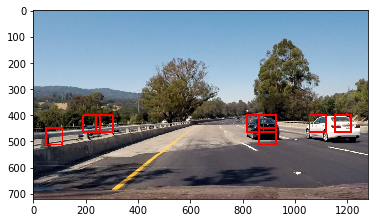

In [129]:
window = 64
ystart = 400
ystop = ystart + (window*3)
print(ystart, ystop)
scale = 1 #Steps 5
t1 = time.time()
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                    cell_per_block, spatial_size, cells_per_step=6, hog_channel=hog_channel, show_windows=False)
print("Time taken", time.time()-t1)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

(400, 656)
('YUV', 'HSV')
(3L, 16L, 87L, 2L, 2L, 9L)
('Time taken', 0.1830000877380371)


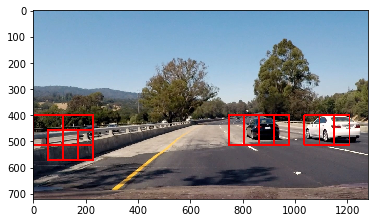

In [128]:
ystart = 400 #+ (window)
ystop = ystart + (window*4)
print(ystart, ystop)
scale = 1.8 #steps 4
    
t1 = time.time()
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                    cell_per_block, spatial_size, cells_per_step=4, hog_channel=hog_channel, show_windows=False)
print("Time taken", time.time()-t1)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.show()